In [1]:
import pandas as pd
import numpy as np
# import cv2
from matplotlib import pyplot as plt

In [2]:
# take 500-7 faces from PIE and 7 selfies as Train
data = pd.read_hdf('train.h5', key='mydata').to_numpy()
selfie_image = np.load('./selfie_image.npy')
np.random.shuffle(data)
n_select = 500
Selfie_select = 7
Labels = data[:n_select - Selfie_select,1]
n_pixel = 1024
face_select = np.zeros((n_select, n_pixel))
for i in range(n_select - Selfie_select):
    face_select[i,:] = data[i,0]
for i in range(Selfie_select):
    face_select[n_select - Selfie_select + i,:] = selfie_image[i].flatten()
    Labels = np.append(Labels, 69)

test_data = pd.read_hdf('test.h5', key='mydata').to_numpy()
PIE_test = np.zeros((test_data.shape[0],1024))
for i in range(PIE_test.shape[0]):
    PIE_test[i,:] = test_data[i,0]
PIE_label = test_data[:,1]

face_train = face_select
Label_train = Labels
selfie_test = np.zeros((3,1024))
for i in range(3):
    selfie_test[i] = selfie_image[7 + i,:,:].flatten()
selfie_label = np.array([[69]*3])
print(
      'Name and Shape of Trainset and Testset:',
      '\n------------------------------------------------------------------',
      '\ntrain       : face_train   |   Label_train       | Shape:', 
      face_train.shape, Label_train.shape[0],
      '\ntest_PIE    : PIE_test     |   PIE_label         | Shape:',
      PIE_test.shape, PIE_label.shape[0],
      '\ntest_selfie : selfie_test  |   selfie_label      | Shape:',
      selfie_test.shape, selfie_label.shape[1]
      )
def Save_dataset():
    np.save('./x_train',face_train)
    np.save('./y_train',Label_train)
    np.save('./x_test_PIE',PIE_test)
    np.save('./y_test_PIE',PIE_label)
    np.save('./x_test_slf',selfie_test)
    np.save('./y_test_slf',selfie_label)
Save_dataset()

Name and Shape of Trainset and Testset: 
------------------------------------------------------------------ 
train       : face_train   |   Label_train       | Shape: (500, 1024) 500 
test_PIE    : PIE_test     |   PIE_label         | Shape: (1275, 1024) 1275 
test_selfie : selfie_test  |   selfie_label      | Shape: (3, 1024) 3


In [3]:
y_train = Label_train
X_train = face_train
# compute withiin label S
ulabels = np.unique(y_train)
feature_means = np.zeros((len(ulabels), 1024))

within_label_s = np.zeros((1024, 1024))

for i in range(len(ulabels)):
    label = ulabels[i]
    label_samples = X_train[y_train == label]  # get sample with current label
    feature_means[i] = np.mean(label_samples, axis=0)  # mean of features for current label
    s = np.zeros_like(within_label_s)
    for label_sample in label_samples:
        s += np.outer((label_sample - feature_means[i]),(label_sample - feature_means[i]))

    within_label_s += s
# print(within_label_s)
# compute between label S
means = np.mean(X_train, axis=0)
between_label_s = np.zeros_like(within_label_s)

for i in range(len(ulabels)):
    label = ulabels[i]
    n = np.count_nonzero(y_train == label)  # number of samples with current label
    between_label_s += n * np.outer((feature_means[i] - means),(feature_means[i] - means))

alpha = 1e-4  # 调整这个参数
within_label_s += np.eye(within_label_s.shape[1]) * alpha
eigvals, eigvecs = np.linalg.eig(np.linalg.inv(within_label_s) @ between_label_s)

order = np.argsort(-eigvals)  
eigvals = eigvals[order]
eigvecs = eigvecs[:, order].real  

# Projection
X_lda = X_train @ eigvecs[:, :9]

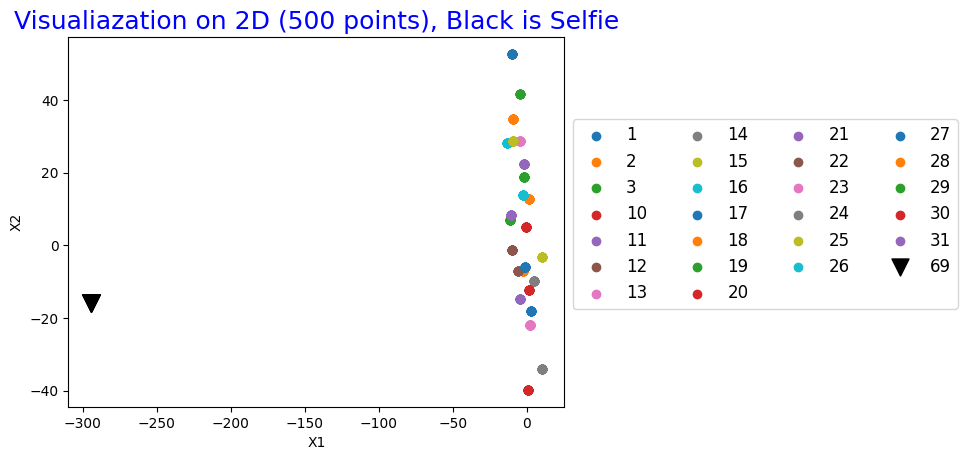

In [4]:
projected_data = X_lda
for i in ulabels:
    if i == 69:
        plt.scatter(projected_data[Labels == i][:,0],
            projected_data[Labels == i][:,1],
            s= 150,
            marker= 'v',
            c= 'black',
            label = i)
    else:
        plt.scatter(projected_data[Labels == i][:,0],
                    projected_data[Labels == i][:,1],
                    label = i)
plt.legend(ncol = 4,bbox_to_anchor = (1,.8),prop = {'size':12})
plt.title('Visualiazation on 2D (500 points), Black is Selfie',fontsize=18, color = 'b')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

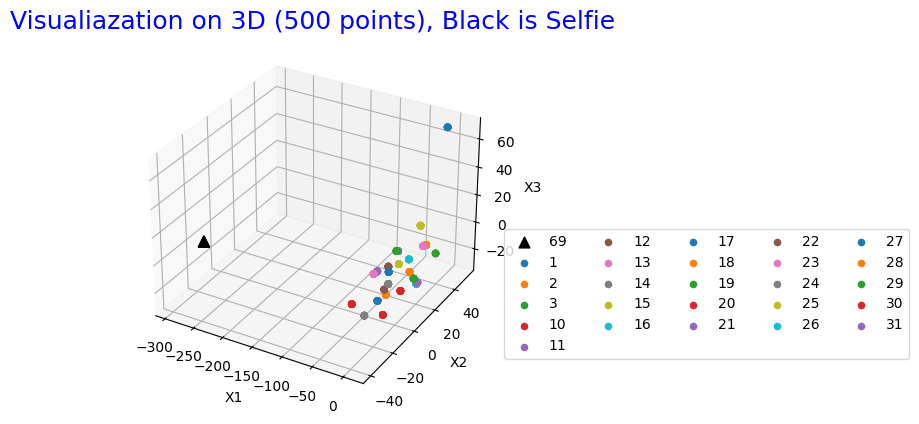

In [5]:
# 3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# highlight point of own photos in dark triangle_up marker
ax.scatter(X_lda[y_train == 69][:, 0],X_lda[y_train == 69][:, 1],X_lda[y_train == 69][:, 2],
           marker="^",label=69,c="k",s=60,)
for i in np.unique(y_train[y_train != 69]):
    ax.scatter(X_lda[y_train == i][:, 0],X_lda[y_train == i][:, 1],X_lda[y_train == i][:, 2],label=i,)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
lgd = ax.legend(ncol=np.int_(25 / 5), bbox_to_anchor=(1, 0.5))
plt.title('Visualiazation on 3D (500 points), Black is Selfie',fontsize=18, color = 'b')
plt.show()

In [8]:
def KNN_classification(k, dim, X_test, y_test):
    distrances = np.linalg.norm(X_test[:, :dim][:, np.newaxis] - X_train[:, :dim], axis=2)
    distrances = np.argsort(distrances)  
    min_idx = distrances[:, :k]
    knn_labels = []
    for i in min_idx:
        y_pred = np.argmax(np.bincount(Label_train[i].astype(int)))
        knn_labels.append(y_pred)
    knn_labels = np.array(knn_labels)
    r_rate = np.sum(knn_labels == y_test) / len(y_test)
    return r_rate

def Print_result(X_test, y_test):
    for i in [2, 3 , 9 ]:
        acc = round(KNN_classification(k=1, dim=i, 
              X_test=X_test, y_test=y_test)* 100, 1)
        print(f'Accuracy = {acc}% | dim = {i}')

def PCA_projection(img, vec):
    img -= np.mean(img, axis=0)
    return img @ vec

vec = eigvecs[:, :9]
X_train = X_lda
PIE_test_projection = PCA_projection(img=PIE_test, vec=vec)
selfie_test_projection = PCA_projection(img=selfie_test, vec=vec)

print('k = 1')
print('-------------------------------------------------------')
print("For PIE:")
Print_result(PIE_test_projection, PIE_label)
print('-------------------------------------------------------')
print("For selfie:")
Print_result(selfie_test_projection, selfie_label)
print('-------------------------------------------------------')

k = 1
-------------------------------------------------------
For PIE:
Accuracy = 20.8% | dim = 2
Accuracy = 30.4% | dim = 3
Accuracy = 66.3% | dim = 9
-------------------------------------------------------
For selfie:
Accuracy = 0.0% | dim = 2
Accuracy = 0.0% | dim = 3
Accuracy = 0.0% | dim = 9
-------------------------------------------------------
